In [2]:
!pip install pandas_profiling

                                              0.0/324.4 kB ? eta -:--:--
     ---------------------------------      286.7/324.4 kB 8.9 MB/s eta 0:00:01
     ------------------------------------- 324.4/324.4 kB 10.1 MB/s eta 0:00:00
                                              0.0/353.0 kB ? eta -:--:--
     ------------------------------------- 353.0/353.0 kB 11.1 MB/s eta 0:00:00
                                              0.0/2.2 MB ? eta -:--:--
     --------------                           0.8/2.2 MB 17.0 MB/s eta 0:00:01
     ------------------------------------     2.0/2.2 MB 21.4 MB/s eta 0:00:01
     ---------------------------------------- 2.2/2.2 MB 20.0 MB/s eta 0:00:00
                                              0.0/102.7 kB ? eta -:--:--
     -------------------------------------- 102.7/102.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/6

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import ensemble
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from pandas_profiling import profile_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

C:\Users\USER\anaconda3\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\USER\anaconda3\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
C:\Users\USER\AppData\Local\Temp\ipykernel_16976\3281089718.py:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st.

# Upload data

In [4]:
train = pd.read_csv("data/train.csv", index_col="id")
test = pd.read_csv("data/test.csv", index_col="id")
origin = pd.read_csv("data/ConcreteStrengthData.csv")
origin = origin.rename(columns={"CementComponent ": "CementComponent"})

train['is_generated'] = 1
test['is_generated'] = 1
origin['is_generated'] = 0

# Make dataset profiles

In [5]:
print(origin.shape[0], train.shape[0])

1030 5407


In [6]:
train_report = train.profile_report()
origin_report = origin.profile_report()

In [7]:
train_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Comparison of test, train and origin

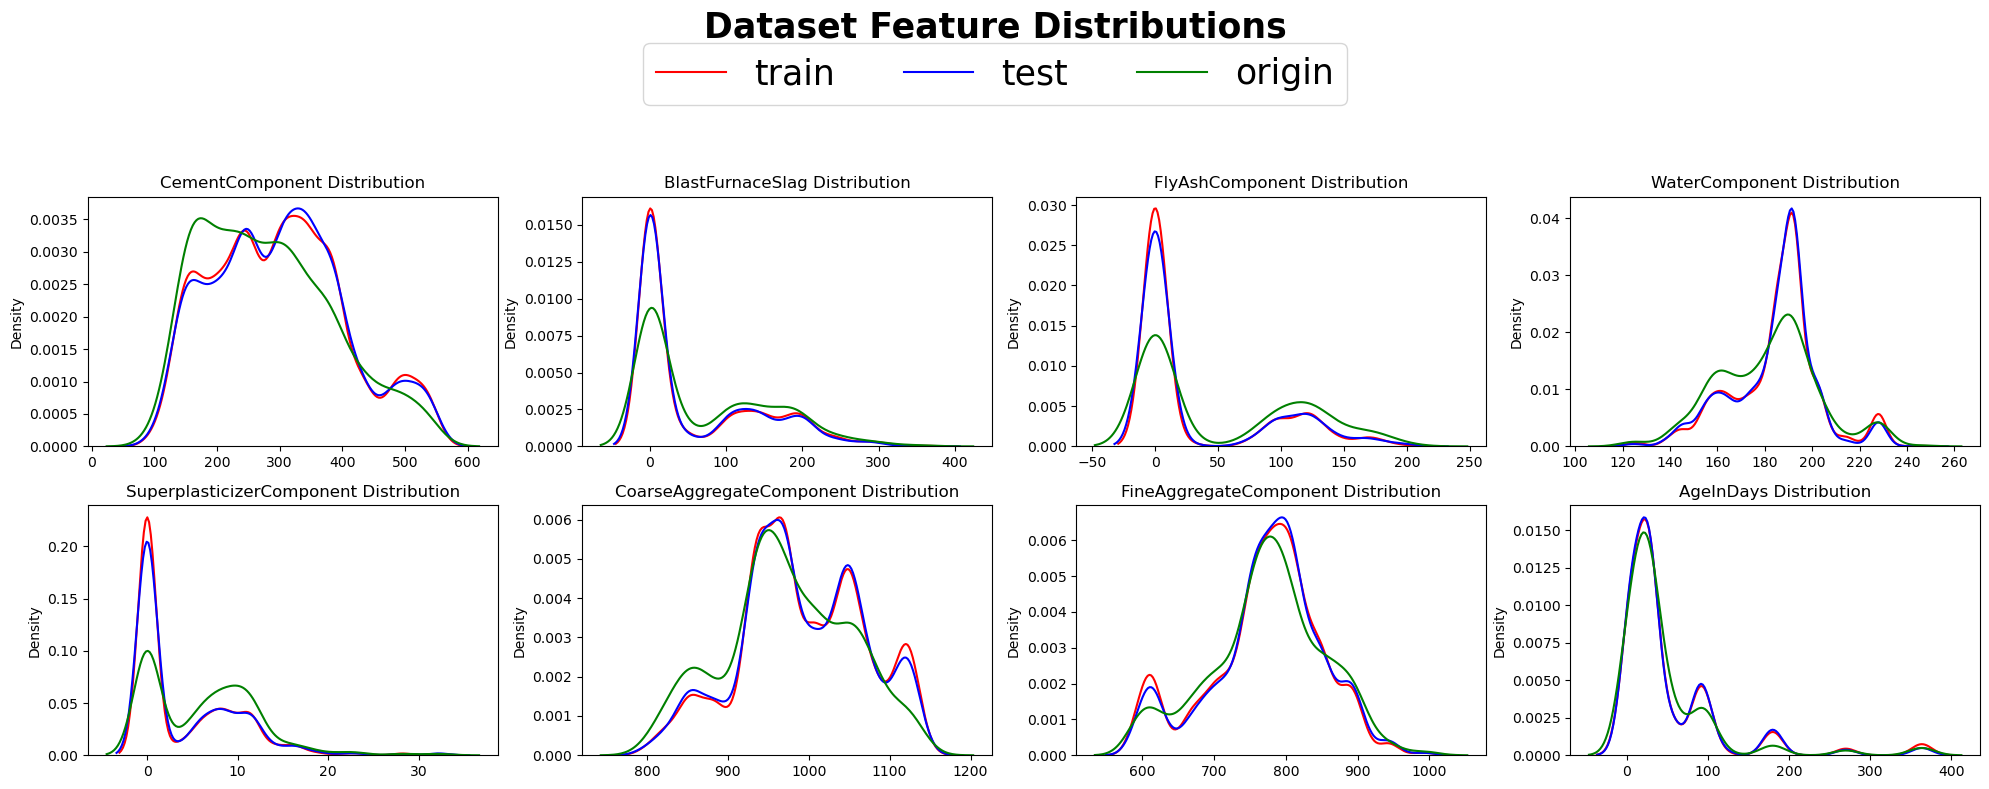

In [8]:
import math
import seaborn as sns
%matplotlib inline


features = origin.drop(columns=["Strength", "is_generated"]).columns
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train[column], label='train',
        ax=ax[i], color='red'
    )
    
    sns.kdeplot(
        test[column], label='test',
        ax=ax[i], color='blue'
    )
    sns.kdeplot(
        origin[column], label='origin',
        ax=ax[i], color='green'
    )
    
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Dataset Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()
# plt.show()

# Add new features and concat origin & train

In [9]:
train = pd.concat([train, origin],axis=0, ignore_index=True)

train['Water_Cement'] = train['WaterComponent']/train['CementComponent']
train['Coarse_Fine'] = train['CoarseAggregateComponent']/train['FineAggregateComponent']
train['Aggregate'] = train['CoarseAggregateComponent'] + train['FineAggregateComponent']
train['Aggregate_Cement'] = train['Aggregate']/train['CementComponent']
train['Slag_Cement'] = train['BlastFurnaceSlag']/train['CementComponent']
train['Ash_Cement'] = train['FlyAshComponent']/train['CementComponent']
train['Plastic_Cement'] = train['SuperplasticizerComponent']/train['CementComponent']
train['Age_Water'] = train['AgeInDays']/train['WaterComponent']

test['Water_Cement'] = test['WaterComponent']/test['CementComponent']
test['Coarse_Fine'] = test['CoarseAggregateComponent']/test['FineAggregateComponent']
test['Aggregate'] = test['CoarseAggregateComponent'] + test['FineAggregateComponent']
test['Aggregate_Cement'] = test['Aggregate']/test['CementComponent']
test['Slag_Cement'] = test['BlastFurnaceSlag']/test['CementComponent']
test['Ash_Cement'] = test['FlyAshComponent']/test['CementComponent']
test['Plastic_Cement'] = test['SuperplasticizerComponent']/test['CementComponent']
test['Age_Water'] = test['AgeInDays']/test['WaterComponent']

# Tune models hyperparameters with optuna

In [10]:
# import lightgbm as lgbm


# def lgbm_objective(trial):
#     learning_rate = trial.suggest_float('learning_rate', 0.000001, 0.1)
#     depth = trial.suggest_int('depth', 2, 10)
#     l1_reg = trial.suggest_float('reg_alpha', 0, 10)
#     l2_reg = trial.suggest_float('reg_lambda', 0, 10)
#     num_leaves = trial.suggest_int('num_leaves', 6, 100)
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#     model = lgbm.LGBMRegressor(
#            n_estimators = 3000, 
#            learning_rate = learning_rate,
#            max_depth = depth,
#            reg_alpha = l1_reg,
#            reg_lambda = l2_reg,
#            num_leaves = num_leaves,
#            device = "gpu",
#     )
    
#     model.fit(X_train, y_train)  
#     error = mean_squared_error(y_test, model.predict(X_test), squared=False)
    
#     return error

# study = optuna.create_study(direction= 'minimize')
# study.optimize(lgbm_objective, n_trials= 1500)
# study.best_params

In [11]:
# from catboost import CatBoostRegressor


# def cb_objective(trial):
#     learning_rate = trial.suggest_float('learning_rate', 0.000001, 0.05)
#     depth = trial.suggest_int('max_depth', 2, 10)
#     l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0, 1)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#     model = CatBoostRegressor(
#            iterations = 3000, 
#            learning_rate = learning_rate,
#            max_depth = depth,
#            task_type = "GPU",
#            devices = "0:1",
#            l2_leaf_reg=l2_leaf_reg,
#     )
    
#     model.fit(X_train, y_train, silent=True, eval_set=(X_test, y_test), early_stopping_rounds=50)  
#     error = mean_squared_error(y_test, model.predict(X_test), squared=False)
    
#     return error

# study = optuna.create_study(direction= 'minimize')
# study.optimize(cb_objective, n_trials= 800)
# study.best_params

In [12]:
# def xgboost_objective(trial):
#     learning_rate = trial.suggest_float('learning_rate', 0.000001, 0.05)
#     depth = trial.suggest_int('depth', 2, 10)
#     learning_rate = trial.suggest_float('learning_rate', 0, 0.05)
#     subsample = trial.suggest_float('subsample', 0.5, 1)
#     regL2 = trial.suggest_float('lambda', 0, 1)
#     regL1 = trial.suggest_float('alpha', 0, 1)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
#     model = XGBRegressor(
#            n_estimators = 3000, 
#            learning_rate = learning_rate,
#            max_depth = depth,
#            tree_method = 'gpu_hist',
#            gpu_id = 0,
#            reg_lambda=regL2,
#            alpha=regL1,
#            subsample=subsample,
#     )
    
#     model.fit(X_train, y_train)  
#     error = mean_squared_error(y_test, model.predict(X_test), squared=False)
    
#     return error

# study = optuna.create_study(direction= 'minimize')
# study.optimize(xgboost_objective, n_trials= 800)
# study.best_params

# Training models ensemble

In [13]:
from sklearn.model_selection import RepeatedKFold


n_folds = 5
n_repeats = 3

X = train.drop(columns=["Strength"])
y = train.Strength

In [14]:
import lightgbm as lgbm


k_fold = RepeatedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

modelsLB = []
predsLB = []

PATIENCE = 50

gpu_params = {'device' : "gpu"}
lgbr_params = {'n_estimators': 2000, 
               'metric': 'rmse',
               'max_depth': 3, 
               'learning_rate': 0.011700296382627928,
               'reg_alpha': 0,
               'reg_lambda': 5,
#                **gpu_params
              }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = lgbm.LGBMRegressor(**lgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsLB.append(model)
    predsLB.append(model.predict(test))

[100]	valid_0's rmse: 12.3022
[200]	valid_0's rmse: 11.6103
[300]	valid_0's rmse: 11.406
[400]	valid_0's rmse: 11.3114
[500]	valid_0's rmse: 11.2627
[600]	valid_0's rmse: 11.2433
[700]	valid_0's rmse: 11.2387
[100]	valid_0's rmse: 12.2745
[200]	valid_0's rmse: 11.6609
[300]	valid_0's rmse: 11.5246
[400]	valid_0's rmse: 11.481
[500]	valid_0's rmse: 11.4543
[600]	valid_0's rmse: 11.4287
[100]	valid_0's rmse: 12.884
[200]	valid_0's rmse: 12.1162
[300]	valid_0's rmse: 11.8731
[400]	valid_0's rmse: 11.7887
[500]	valid_0's rmse: 11.7405
[600]	valid_0's rmse: 11.7127
[700]	valid_0's rmse: 11.6935
[800]	valid_0's rmse: 11.6813
[900]	valid_0's rmse: 11.6729
[1000]	valid_0's rmse: 11.6662
[1100]	valid_0's rmse: 11.6523
[1200]	valid_0's rmse: 11.6377
[1300]	valid_0's rmse: 11.6294
[1400]	valid_0's rmse: 11.6229
[1500]	valid_0's rmse: 11.6192
[100]	valid_0's rmse: 12.8245
[200]	valid_0's rmse: 12.0323
[300]	valid_0's rmse: 11.8014
[400]	valid_0's rmse: 11.7179
[500]	valid_0's rmse: 11.6833
[600]	v

In [15]:
# from xgboost import XGBRegressor

# k_fold = RepeatedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

# modelsXB = []
# predsXB = []

# PATIENCE = 50

# xgbr_params = {'n_estimators': 3000, 
#                'learning_rate': 0.015875505556693453, 'depth': 2, 'subsample': 0.5779650875928081, 'lambda': 0.4616951012196189, 'alpha': 0.9423445035214505,
# #                'tree_method': 'gpu_hist',
# #                'gpu_id': 0,
#               }


# for train_index, test_index in k_fold.split(X, y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
#     model = XGBRegressor(**xgbr_params)
    
#     model.fit(X=X_train, y=y_train,
#           eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = PATIENCE,
#           verbose = 100
#          )
#     modelsXB.append(model)
#     predsXB.append(model.predict(test))


In [16]:
# import torch
# import torch.nn as nn
# import torch.utils.data as data_utils
# import torch.nn.functional as F


# device = torch.device('cuda:0')

# class Reg(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(len(X.columns), 32)
#         self.dense1_bn = nn.BatchNorm1d(32)
#         self.fc2 = nn.Linear(32, 16)
#         self.dense2_bn = nn.BatchNorm1d(16)
# #         self.fc3 = nn.Linear(32, 16)
# #         self.dense3_bn = nn.BatchNorm1d(16)
#         self.fc4 = nn.Linear(16, 1)
        
#     def forward(self, x):
#         x = F.relu(self.dense1_bn(self.fc1(x)))
#         x = F.relu(self.dense2_bn(self.fc2(x)))
# #         x = F.relu(self.dense3_bn(self.fc3(x)))
#         x = F.relu(self.fc4(x))
#         return x

# x_train_tensor = torch.from_numpy(X.values).float().to(device)
# y_train_tensor = torch.from_numpy(y.values).float().to(device)

# model = Reg()
# loss_fn = nn.MSELoss()
# optim =  torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))
# model.to(device)

# dataset = data_utils.TensorDataset(x_train_tensor, y_train_tensor)
# train_loader = data_utils.DataLoader(dataset, batch_size=8, shuffle=True)

# losses = []
# for i in range(50):
#     for x_batch, y_batch in train_loader:
#         x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
#         y_batch = y_batch.type(torch.FloatTensor).to(device)
#         y_pred = model(x_batch.float()).to(device)

#         loss = loss_fn(y_pred, y_batch)
#         losses.append(loss.item())

#         optim.zero_grad()
#         loss.backward()
#         optim.step()
#     if(i % 10 == 0):
#         print(f"epochs: {i}......loss:{(losses[-1])}")
# plt.plot(losses)

# predNN = model(torch.tensor(torch.from_numpy(test.values).float().to(device),dtype=torch.float32)).cpu().detach().numpy()

In [17]:
from sklearn.ensemble import GradientBoostingRegressor


k_fold = RepeatedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

modelsSGB = []
predsSGB = []

par =  {
    'n_estimators': 1000,
    'learning_rate': 0.0095,
    'min_samples_split': 4,
    'max_features': "sqrt",
    'validation_fraction': 0.2,
    'n_iter_no_change': 5,
    'tol': 0.01,
    'random_state': 0,    
}


for train_index, test_index in k_fold.split(X, y):
    
    model = GradientBoostingRegressor(**par)
    
    model.fit(X, y)
    modelsSGB.append(model)
    predsSGB.append(model.predict(test))

In [18]:
# PATIENCE = 50

# modelsCB = []
# predsCB = []

# k_fold = RepeatedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

# gpu_params = {'task_type' : "GPU", 'devices' : '0:1'}
# cbr_params = {'iterations': 3000, 
#               'max_depth': 7,
#               'learning_rate': 0.048082191391374554,
#               'verbose': 100,
# #               **gpu_params
#              }

# for train_index, test_index in k_fold.split(X, y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
#     model = CatBoostRegressor(**cbr_params)
    
#     model.fit(X=X_train, y=y_train,
#           eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = PATIENCE,
#          )
#     modelsCB.append(model)
#     predsCB.append(model.predict(test))

In [19]:
# !pip install --quiet pytorch-tabnet

In [20]:
# import torch
# from pytorch_tabnet.tab_model import TabNetRegressor


# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# kf = RepeatedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)
# predictions_array = []
# CV_score_array = []

# X_tbnet = X.values
# y_tbnet = y.values.reshape(-1, 1)

# for train_index, test_index in kf.split(X_tbnet):
#     X_train, X_valid = X_tbnet[train_index], X_tbnet[test_index]
#     y_train, y_valid = y_tbnet[train_index], y_tbnet[test_index]
    
#     regressor = TabNetRegressor(verbose=0,seed=42,device_name=DEVICE)
    
#     regressor.fit(X_train=X_train, y_train=y_train,
#               eval_set=[(X_valid, y_valid)],
#               patience=10, max_epochs=2000,
#               eval_metric=['rmse'])
    
#     CV_score_array.append(regressor.best_cost)
#     predictions_array.append(regressor.predict(test.values))

# Make submit

In [21]:
# predCB = np.average(np.array(predsCB),axis=0)
# predXB = np.average(np.array(predsXB),axis=0)
predLGBM = np.average(np.array(predsLB),axis=0)
predSGR = np.average(np.array(predsSGB),axis=0)
# predLR = np.average(np.array(predsLR),axis=0)
# predTBNET = np.average(np.array(predictions_array),axis=0).reshape(-1)

coef = 0.5

a = b = c = d = e = coef

In [22]:
subm = pd.DataFrame()
subm["id"] = test.index
subm = subm.set_index("id")
subm["Strength"] = predSGR * a + predLGBM * d

subm.to_csv('submission.csv')